## 216 - Creating PDF Reports in Python Part 3

[Youtube](https://www.youtube.com/watch?v=uwx7pAJpfhk)

In [1]:
from fpdf import FPDF

In [2]:
class PDF(FPDF):
    def header(self):
        self.image('unidata.png', w = 20)
        self.set_font('Arial', 'B', 11)
        self.set_xy(0, 0)
        self.cell(200, 40, 'Current Buoy Summary', 0, 0, 'R')
        self.ln(20)

    def footer(self):
        self.set_y(-15)
        self.set_font('Arial', 'I', 8)
        self.cell(0, 10, 'Page ' + str(self.page_no()) + '/{nb}', 0, 0, 'C')

In [3]:
from siphon.simplewebservice.ndbc import NDBC
from datetime import datetime

In [4]:
df = NDBC.latest_observations()
df.columns
df.describe()

,latitude,longitude,wind_direction,wind_speed,wind_gust,wave_height,dominant_wave_period,average_wave_period,dominant_wave_direction,pressure,3hr_pressure_tendency,air_temperature,water_temperature,dewpoint,visibility,water_level_above_mean
count,886.000000,886.000000,649.000000,678.000000,580.000000,193.000000,164.000000,96.000000,115.000000,612.000000,120.000000,691.000000,534.000000,298.000000,54.000000,33.000000
mean,39.445702,-92.654859,164.255778,5.124484,7.263448,1.124870,7.445122,5.916667,155.382609,1018.323366,-0.408333,17.079305,20.627528,11.533221,10.762963,1.562121
std,12.108456,44.474016,115.686995,3.653895,4.695503,1.016532,3.888402,1.413221,108.865971,8.110799,1.078482,5.768944,6.105696,5.138349,8.590853,1.588428
min,-22.000000,-177.703000,0.000000,0.000000,0.000000,0.000000,2.000000,2.100000,5.000000,984.600000,-3.000000,-1.500000,-0.300000,-1.500000,1.600000,-1.810000
25%,30.034750,-122.461250,60.000000,2.600000,4.000000,0.300000,4.000000,5.000000,52.500000,1012.600000,-1.200000,13.150000,15.825000,8.225000,5.900000,1.020000
50%,40.640000,-86.426000,140.000000,4.100000,6.200000,0.900000,8.000000,6.100000,142.000000,1017.400000,-0.550000,15.800000,20.600000,10.900000,6.450000,1.480000
75%,46.644750,-76.730750,270.000000,7.000000,9.800000,1.600000,10.000000,7.000000,246.500000,1025.900000,0.325000,21.750000,26.800000,13.975000,11.000000,1.580000
max,71.315000,179.784000,360.000000,23.700000,27.800000,5.800000,18.000000,8.900000,358.000000,1031.500000,2.300000,34.800000,31.400000,25.900000,27.000000,7.420000


In [5]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from metpy.plots import StationPlot
import metpy.calc as mpcalc
from metpy.units import units

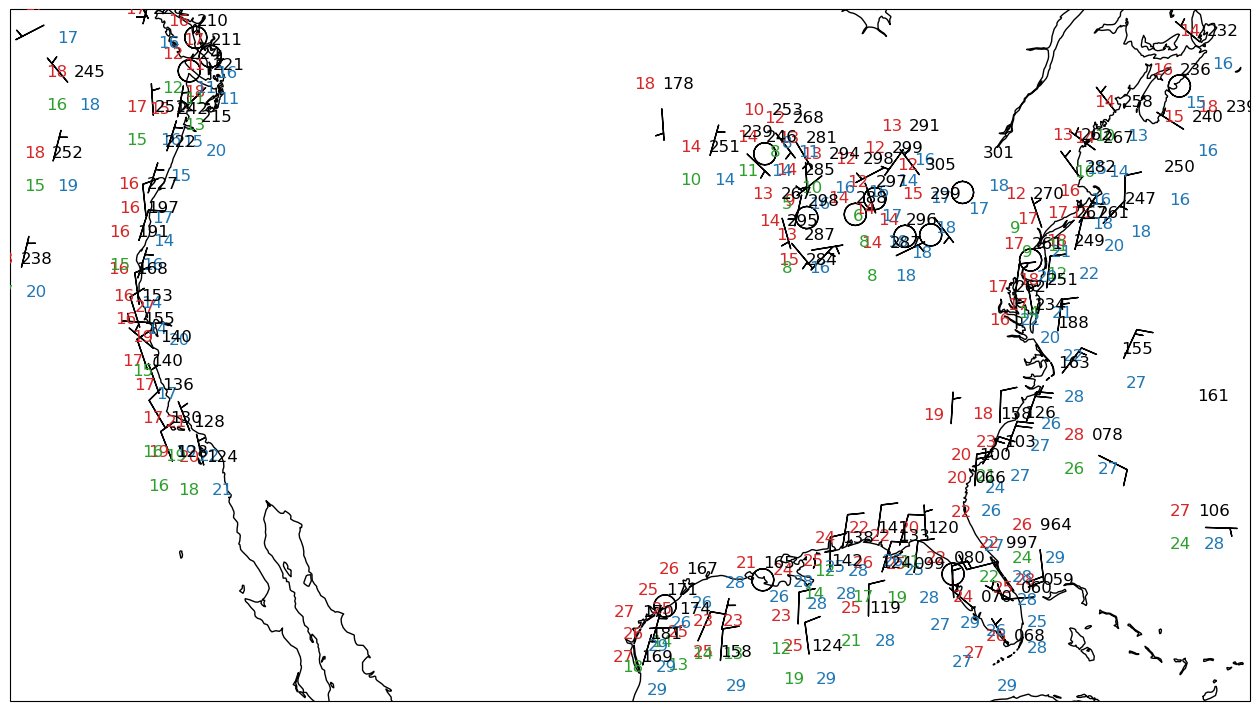

In [6]:
df['u_wind'], df['v_wind'] = mpcalc.wind_components(df['wind_speed'].values * units('m/s'), df['wind_direction'].values * units('degrees'))

proj = ccrs.LambertConformal(central_latitude = 45, central_longitude = -100, standard_parallels = [30, 60])
point_locs = proj.transform_points(ccrs.PlateCarree(), df['longitude'].values, df['latitude'].values)
df = df[mpcalc.reduce_point_density(point_locs, 100000)]


fig = plt.figure(figsize = (16, 10))
ax = plt.axes(projection = proj)
ax.coastlines('50m', edgecolor = 'black')
ax.set_extent([-125, -70, 25, 50], ccrs.PlateCarree())

stationplot = StationPlot(ax, df['longitude'].values, df['latitude'].values, clip_on = True, transform = ccrs.PlateCarree(), fontsize = 12)
stationplot.plot_parameter('NW', df['air_temperature'].values, color = 'tab:red')
stationplot.plot_parameter('SW', df['dewpoint'].values, color = 'tab:green')
stationplot.plot_parameter('SE', df['water_temperature'].values, color = 'tab:blue')
stationplot.plot_parameter('NE', df['pressure'].values, color = 'black', formatter = lambda v: format(10 * v, '.0f')[-3:])
stationplot.plot_barb(df['u_wind'].values, df['v_wind'].values)

plt.savefig('CONUS_map.png')


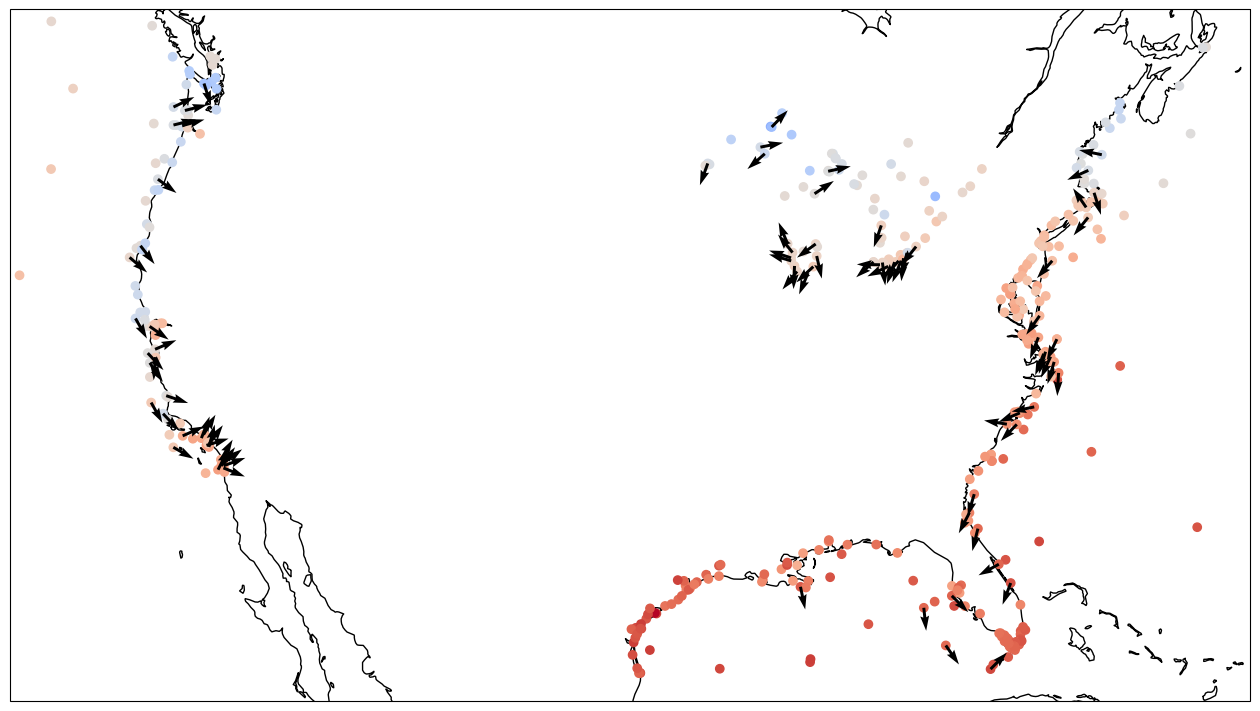

In [7]:
df = NDBC.latest_observations()
df['u_wave'], df['v_wave'] = mpcalc.wind_components (10 * units('m/s'), df['dominant_wave_direction'].values * units.degrees)

fig = plt.figure(figsize = (16,10))
ax = plt.axes(projection = proj)
ax.coastlines('50m', edgecolor = 'black')
ax.set_extent([-125, -70, 25, 50], ccrs.PlateCarree())
ax.scatter(df['longitude'], df['latitude'], c = df['water_temperature'], transform = ccrs.PlateCarree(), cmap = 'coolwarm')
ax.quiver(df['longitude'].values, df['latitude'].values, df['u_wave'].values, df['v_wave'].values, transform = ccrs.PlateCarree())
plt.savefig('CONUS_vectors.png')

In [8]:
pdf = PDF()
pdf.add_page()
pdf.alias_nb_pages()
pdf.set_font('Arial', 'B', 16)
pdf.cell(60, 40, f'{datetime.utcnow():%Y-%m-%d %H:%M}')

report_vars = ['wind_speed', 'wind_gust', 'wave_height', 'dominant_wave_period', 'average_wave_period', 
               'dominant_wave_direction', 'pressure', 'air_temperature', 'water_temperature', 'dewpoint', 
               'visibility']

df_describe = df.describe()
pdf.set_font('Arial', 'B', 12)
y_height = 5
pdf.set_xy(10, 50)
pdf.cell(25)
pdf.cell(60, y_height, 'Variable', border = 1)
for label in ['Mean', 'Min', 'Max']:
    pdf.cell(20, y_height, label, border = 1)
pdf.cell(20, y_height, 'Std Dev.', border = 1, ln = 1)

pdf.set_font('Arial', '', 12)
for var in report_vars:
    pdf.cell(25)
    pdf.cell(60, y_height, var, border = 1)
    for stat in ['mean', 'min', 'max']:
        pdf.cell(20, y_height, str(round(df_describe[var][stat], 1)), border = 1)
    pdf.cell(20, y_height, str(round(df_describe[var]['std'], 1)), border = 1, ln = 1)

pdf.set_xy(0, 120)
pdf.image('CONUS_map.png', w = 160, h = 100)
pdf.add_page()
pdf.set_xy(0, 60)
pdf.image('CONUS_vectors.png', w = 160, h = 100)

pdf.output('report.pdf', 'F')

''